In [36]:
%pip install gurobipy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
# Overleaf Link: https://www.overleaf.com/7717938235zvyzkyhqrxdb
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import random
import time
import matplotlib

In [38]:
## Import Data
import_start_time = time.time()
nodes = []
edges = []

# parsing node data, change the file name to what you want for larger or other topos
node_file = open('nodes.txt', 'r')
node_lines = node_file.readlines()
for node_line in node_lines:
  nodes.append(node_line.replace('\n', ''))

node_file.close()

# parsing edge data, change the file name ...
edge_file = open('topology.txt', 'r')
edge_lines = edge_file.readlines()[1:]
for edge_line in edge_lines:
  edge = edge_line.split()
  if not (edge[0:3] in edges or [edge[1], edge[0], edge[2]] in edges):
    edges.append(edge[0:3])

edge_file.close()

import_time = time.time() - import_start_time

print(edges)
print(nodes)


[['9', '10', '1000000000'], ['9', '8', '1000000000'], ['9', '4', '1000000000'], ['8', '3', '1000000000'], ['8', '7', '1000000000'], ['8', '4', '1000000000'], ['3', '4', '1000000000'], ['2', '0', '1000000000'], ['1', '10', '1000000000'], ['1', '6', '1000000000'], ['0', '7', '1000000000'], ['0', '4', '1000000000'], ['7', '10', '1000000000'], ['7', '6', '1000000000'], ['6', '10', '1000000000'], ['6', '5', '1000000000'], ['5', '4', '1000000000'], ['4', '10', '1000000000']]
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


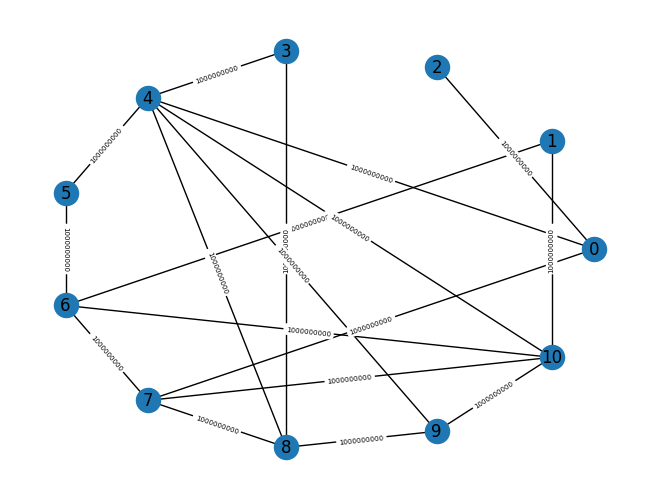

In [39]:
## Draw Network
G = nx.Graph()
G.add_nodes_from(nodes)
for i in range(len(nodes)):
  G.nodes[str(i)]['pos'] = (random.uniform(0,5), random.uniform(0,5))
for edge in edges:
  G.add_edge(edge[0], edge[1], bandwidth = edge[2])

# getting the pretty circular layout
pos = nx.circular_layout(G)
nx.draw(G,pos, with_labels=True)
labels = nx.get_edge_attributes(G,'bandwidth')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=5)
matplotlib.pyplot.savefig('./topology')


In [40]:
# demands formatted as a list of lists of lists, where each entry corresponds to a
# timestamp, increasing as time progresses. Each list within is a list 
# of lists where each corresponds to demands for that node pair at 
# that time, e.g. demands[0][3][7] is the demand initially from node 4
# to node 8
graph_setup_start = time.time()
demands = []
# similar to the node and edge file, change file name to ...
demand_file = open('demand.txt', 'r')
demand_lines = demand_file.readlines()
for demand_line in demand_lines:
  demand = demand_line.split()
  t_demand = [demand[i:i + 11] for i in range(0, len(demand), 11)]
  demands.append(t_demand)

# finding the maximum demand matrix
max_demand_matrix = None
max_total = 0
for timestamp in demands:
  total = 0
  for i in range(len(timestamp)):
    for j in range(len(timestamp[0])):
      total += float(timestamp[i][j])
  if total > max_total:
    max_total = total
    max_demand_matrix = timestamp
  
#mapping for each edge
edge_mapping = {}

from collections import defaultdict

class Graph:
  
    def __init__(self, vertices):
        # No. of vertices
        self.V = vertices
         
        # default dictionary to store graph
        self.graph = defaultdict(list)
  
    # function to add an edge to graph
    def addEdge(self, u, v):
        self.graph[u].append(v)

    def printAllPathsUtil(self, u, d, visited, path, lst):
 
        # Mark the current node as visited and store in path
        visited[u]= True
        path.append(u)
 
        # If current vertex is same as destination, then print
        # current path[]
        if u == d:
            lst.append(path.copy())
        else:
            # If current vertex is not destination
            # Recur for all the vertices adjacent to this vertex
            for i in self.graph[u]:
                if visited[i]== False:
                    self.printAllPathsUtil(i, d, visited, path, lst)
                     
        # Remove current vertex from path[] and mark it as unvisited
        path.pop()
        visited[u]= False
  
  
    # Prints all paths from 's' to 'd'
    def printAllPaths(self, s, d, lst):
 
        # Mark all the vertices as not visited
        visited =[False]*(self.V)
 
        # Create an array to store paths
        path = []
 
        # Call the recursive helper function to print all paths
        self.printAllPathsUtil(s, d, visited, path, lst)
        

g = Graph(len(nodes))
for edge in edges:
  g.addEdge(int(edge[0]), int(edge[1]))
  g.addEdge(int(edge[1]), int(edge[0]))

paths = []

# finding the 5 shortests paths for every pair of nodes

routes = []
for node in nodes:
  for dest_node in nodes:
    if node != dest_node:
      g.printAllPaths(int(node), int(dest_node), paths)
      paths.sort(key = len)
      for p in paths[0:5]:
        routes.append(p)
      paths = []

graph_setup_time = time.time() - graph_setup_start



In [41]:
# max throughput
edge_sols = {}
try:
    set_up_start_time = time.time()
   # Create a new model
    m = gp.Model("te1")

    for edge in edges:
      edge_mapping[str(edge)] = None

    edge_vars = []
    # Create variables - for each edge
    counter = 0
    for edge in edges:
      edge_name = "e" + str(counter)
      counter += 1
      globals()[edge_name] = m.addVar(vtype=GRB.CONTINUOUS, name=edge_name)
      edge_vars.append(globals()[edge_name])

    for i in range(len(edges)):
      edge_mapping[str(edges[i])] = edge_vars[i]

    route_map = {}

    for route in routes:
      path_for_route = []
      for i in range(len(route)):
        if len(route) - i > 1:
          try:
            e = edge_mapping[str([str(route[i]), str(route[i+1]), '1000000000'])]
          except:
            e = edge_mapping[str([str(route[i+1]), str(route[i]), '1000000000'])]
          path_for_route.append(e)
      route_map[str(route)] = path_for_route
    path_num = 0

    total_flow = 0

    # making vars for every route + constructing the total flow value
    for route in route_map:
      v = m.addVar(vtype = GRB.CONTINUOUS, name = "path" + str(path_num))
      total_flow += v
      path_num += 1
      edges_of_path = route_map[route]
      route_map[route] = (v, edges_of_path)

    # the objective to maximize total throughput
    m.setObjective(total_flow, GRB.MAXIMIZE)
    
    # making demand vars
    for i in range(len(max_demand_matrix)):
      for j in range(len(max_demand_matrix[0])):
        if i != j:
          route_vars= []
          for route in route_map:
            origin = 0
            end = 0
            div = route.index(',')
            origin = int(route[1:div])
            div1 = route.rfind(',')
            end = int(route[div1 + 1: len(route) - 1])
            if origin == i and end == j:
              route_vars.append(route_map[route][0])
          demand = max_demand_matrix[i][j]
          d_var = m.addVar(vtype = GRB.CONTINUOUS, name = 'dem' + str(i) + ', ' + str(j))
          m.addConstr(d_var == float(demand))
          paths_sum = 0
          for path_var in route_vars:
            paths_sum += path_var
          m.addConstr(paths_sum <= d_var)
    
    m.update()

    # every edge is the sum of the paths its in
    for e_var in edge_vars:
      path_sum = 0
      for route in route_map:
        p_var = route_map[route][0]
        edge_vs = route_map[route][1]
        for ed in edge_vs:
          if ed.VarName == e_var.VarName:
            path_sum += p_var
      m.addConstr(path_sum == e_var)

    # ensuring allocations do not exceed capacity
    for edge in edge_vars:
      m.addConstr(edge <= 1000000000)

    # Optimize model
    m.update()
    set_up_time = time.time() - set_up_start_time
    print("set up time: " + str(set_up_time + graph_setup_time + import_time))

    optimize_start_time = time.time()
    m.optimize()
    optimize_time = time.time() - optimize_start_time
    print("optimization time: " + str(optimize_time))

    for v in m.getVars():
        print('%s %g' % (v.VarName, v.X))

    print('Obj: %g' % m.ObjVal)

    for i in range(len(edge_vars)):
      edge_sols[i] = edge_vars[i].X

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

set up time: 0.11362195014953613
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 256 rows, 670 columns and 2456 nonzeros
Model fingerprint: 0xb7c30184
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+02, 1e+09]
Presolve removed 256 rows and 670 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4507258e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.450725845e+07
optimization time: 0.004415035247802734
e0 7.12059e+06
e1 8.99477e+06
e2 8.20365e+06
e3 1.78639e+06
e4 1.01255e+07
e5 3.74323e+06
e6 1.14366e+06
e7 4.53618e+06
e8 1.4754e+06
e9 1.5188e+06
e10 1.2138e+07
e11 6.63496e+06
e12 6.0913e+

{0: 7120588.467680999, 1: 8994766.906591, 2: 8203649.886721001, 3: 1786390.183248, 4: 10125549.494825, 5: 3743233.7264730004, 6: 1143657.166961, 7: 4536175.493927999, 8: 1475400.4114710004, 9: 1518795.5650320002, 10: 12138040.972296003, 11: 6634957.993990001, 12: 6091303.129176, 13: 4519145.3982649995, 14: 1499956.9994690004, 15: 2589114.340977, 16: 5388072.4097339995, 17: 3809347.8434849996}


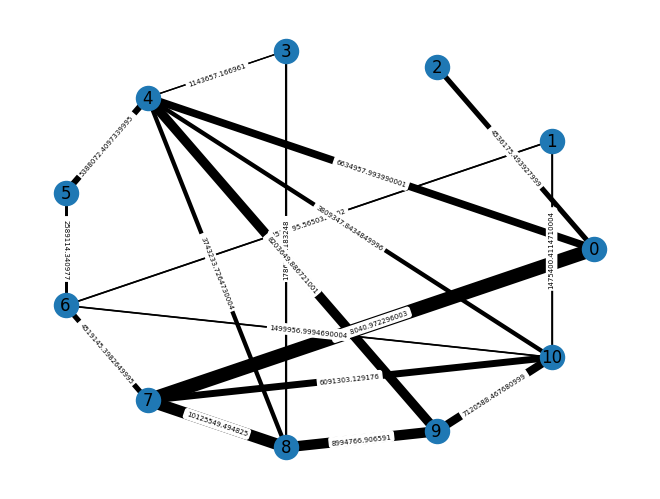

In [42]:
##VISUALISING STEP 4
print(edge_sols)
Go = nx.Graph()
Go.add_nodes_from(nodes)
# makes the positions of the graphs synced

for i in range(len(nodes)):
  Go.nodes[str(i)]['pos'] = pos[str(i)]

ct = 0
for edge in edges:
  Go.add_edge(edge[0], edge[1], bandwidth = edge_sols[ct])
  ct += 1

edge_widths = []
max_width = max(edge_sols.values())
for sol in edge_sols:
  edge_widths.append(10 * (edge_sols[sol]/max_width))

pos = nx.circular_layout(Go)
nx.draw(Go,pos, with_labels=True)
labels = nx.get_edge_attributes(Go,'bandwidth')
for edge in Go.edges(data = 'bandwidth'):
  nx.draw_networkx_edges(Go, pos, edgelist = [edge], width = 10 * edge[2]/max_width)
nx.draw_networkx_edge_labels(Go,pos,edge_labels=labels, font_size=5)
matplotlib.pyplot.savefig('./circ_1')


In [43]:
##STEP 5
edge_sols_step5 = {}
try:
    set_up_start_time = time.time()
   # Create a new model
    m = gp.Model("te1")

    for edge in edges:
      edge_mapping[str(edge)] = None

    edge_vars = []
    # Create variables - for each edge
    counter = 0
    for edge in edges:
      edge_name = "e" + str(counter)
      counter += 1
      globals()[edge_name] = m.addVar(vtype=GRB.CONTINUOUS, name=edge_name)
      edge_vars.append(globals()[edge_name])

    for i in range(len(edges)):
      edge_mapping[str(edges[i])] = edge_vars[i]

    route_map = {}

    for route in routes:
      path_for_route = []
      for i in range(len(route)):
        if len(route) - i > 1:
          try:
            e = edge_mapping[str([str(route[i]), str(route[i+1]), '1000000000'])]
          except:
            e = edge_mapping[str([str(route[i+1]), str(route[i]), '1000000000'])]
          path_for_route.append(e)
      route_map[str(route)] = path_for_route
    path_num = 0
    for route in route_map:
      v = m.addVar(vtype = GRB.CONTINUOUS, name = "path" + str(path_num))
      path_num += 1
      edges_of_path = route_map[route]
      route_map[route] = (v, edges_of_path)

    # Var for max_edge
    max_edge = m.addVar(vtype = GRB.CONTINUOUS, name = "max_edge")

    # Set objective - maximize flow sum over all edges
    m.setObjective(max_edge, GRB.MINIMIZE)
    
    for i in range(len(max_demand_matrix)):
      for j in range(len(max_demand_matrix[0])):
        if i != j:
          route_vars= []
          for route in route_map:
            origin = 0
            end = 0
            div = route.index(',')
            origin = int(route[1:div])
            div1 = route.rfind(',')
            end = int(route[div1 + 1: len(route) - 1])
            if origin == i and end == j:
              route_vars.append(route_map[route][0])
          demand = max_demand_matrix[i][j]
          d_var = m.addVar(vtype = GRB.CONTINUOUS, name = 'dem' + str(i) + ', ' + str(j))
          m.addConstr(d_var == float(demand))
          paths_sum = 0
          for path_var in route_vars:
            paths_sum += path_var
          m.addConstr(paths_sum == d_var)
    
    # Constraint 1.5 - every edge is the sum of paths its in
    m.update()

    for e_var in edge_vars:
      path_sum = 0
      for route in route_map:
        p_var = route_map[route][0]
        edge_vs = route_map[route][1]
        for ed in edge_vs:
          if ed.VarName == e_var.VarName:
            path_sum += p_var
      m.addConstr(path_sum == e_var)

    # Constraint 2 - ensuring allocations do not exceed capacity
    for edge in edge_vars:
      m.addConstr(edge <= 1000000000)

    m.addConstr(max_edge == gp.max_(edge_vars))

    # Optimize model
    m.update()
    set_up_time = time.time() - set_up_start_time
    print("set up time: " + str(set_up_time))

    optimize_start_time = time.time()
    m.optimize()
    optimize_time = time.time() - optimize_start_time
    print("optimization time: " + str(optimize_time))

    for v in m.getVars():
        print('%s %g' % (v.VarName, v.X))

    print('Obj: %g' % m.ObjVal)

    for i in range(len(edge_vars)):
      edge_sols_step5[i] = edge_vars[i].X

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

set up time: 0.0998990535736084
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 256 rows, 671 columns and 2456 nonzeros
Model fingerprint: 0x91156e3a
Model has 1 general constraint
Variable types: 671 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+02, 1e+09]
Presolve removed 141 rows and 218 columns
Presolve time: 0.00s
Presolved: 115 rows, 453 columns, 1690 nonzeros
Variable types: 453 continuous, 0 integer (0 binary)

Root relaxation: objective 4.536175e+06, 11 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    4536175.4939 4536175.49  0.00%     -

{0: 880974.728242, 1: 287038.44679200003, 2: 1514800.146233, 3: 1310914.95193, 4: 2787298.765695, 5: 1890683.452826, 6: 2053323.2548670003, 7: 4536175.493928, 8: 810912.0668960001, 9: 317384.79099300003, 10: 1933522.6147580002, 11: 4536175.493928, 12: 1584040.8651120001, 13: 1950960.9600250002, 14: 2965820.936234, 15: 4536175.493928, 16: 4536175.493928, 17: 4089220.208448999}


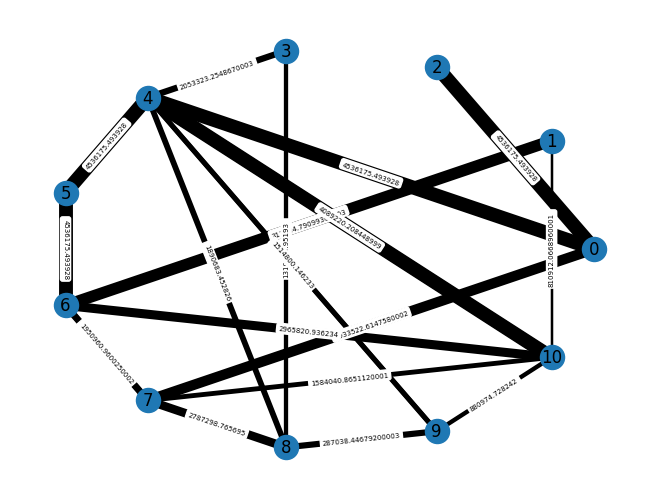

In [44]:
##VISUALISING STEP 5
#Need to reorder edge shit
print(edge_sols_step5)
Gx = nx.Graph()
Gx.add_nodes_from(nodes)

for i in range(len(nodes)):
  Gx.nodes[str(i)]['pos'] = pos[str(i)]

ct = 0

for edge in edges:
  Gx.add_edge(edge[0], edge[1], bandwidth = edge_sols_step5[ct])
  ct += 1

max_width = max(edge_sols_step5.values())

nx.draw(Gx,pos, with_labels=True, width = edge_widths)
for edge in Gx.edges(data = 'bandwidth'):
  nx.draw_networkx_edges(Gx, pos, edgelist = [edge], width = 10 * edge[2]/max_width)
labels = nx.get_edge_attributes(Gx,'bandwidth')
nx.draw_networkx_edge_labels(Gx,pos,edge_labels=labels, font_size=5)
matplotlib.pyplot.savefig('./circ_2')


# Random Network Generator
(For Extra Credit Section)

INPUTS: \\
num_nodes - number of nodes \\
network_density - how interconnected nodes of the network are \\
avg_edge_capacity - average capacity of edges \\
edge_capacity_randomness - variation in edge capacity \\
time_stamps - number of time stamps \\
avg_demand - average node-pair demand \\
demand_randomness - variation in demand \\
edge_prob_failure - prob_failure for each edge \\
 \\
OUTPUTS: \\
nodes.txt \\
topology.txt \\
demand.txt \\


In [45]:
import random

def generate_network(num_nodes, net_dens = 0.5, avg_edge_cap = 1000000000, 
                     edge_cap_rand = 0, time_stamps = 100, avg_demand = 2000, demand_rand = 1, 
                     edge_prob_fail = 0.004):
  node_file_name = str(num_nodes) + "node.txt"
  with open(node_file_name, 'a') as f:
    i = 0
    while (i < num_nodes):
        f.write(str(i) + '\n')
        i += 1


  topology_file_name = str(num_nodes) + "topology.txt"
  with open(topology_file_name, 'a') as g:
    i = 0
    while (i < num_nodes):
        j = 0
        while (j < num_nodes):
            has_edge = (random.random() < (num_nodes*net_dens)/num_nodes) and (i != j)
            if (has_edge):
                edge_cap = avg_edge_cap+((random.uniform(-1*edge_cap_rand, edge_cap_rand))*avg_edge_cap)
                g.write(str(j) + " " + str(i) + " " + str(int(edge_cap)) + " " + str(edge_prob_fail) + '\n')
            j += 1
        i += 1


  demand_file_name = str(num_nodes) + "demand.txt"
  with open(demand_file_name, 'a') as h:
    k = 0
    while (k < time_stamps):
        node_demands = ""
        i = 0
        while (i < num_nodes):
            j = 0
            while (j < num_nodes):
                if (i != j):
                    demand = avg_demand+((random.uniform(-1*demand_rand, demand_rand))*avg_demand)
                    node_demands += (str(demand) + " ")
                j += 1
            i += 1
        h.write(node_demands[:-1] + '\n')
        k += 1

generate_network(5, 0.3, 1000000000, 0)